# Mnist Demos with low level Tensorflow API

# Setup

In [1]:
%%bash
rm -rf tensorflow_logs_cnn

In [1]:
import tensorflow as tf
# Import MINST data
import tensorflow.examples.tutorials.mnist.input_data as input_data
from tensorflow.python.ops import image_ops as img
mnist = input_data.read_data_sets("mnist/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
# for visualization
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from ipywidgets import interact

# Parameter

In [3]:
# Parameters
learning_rate = 0.001
training_iters = 100000
batch_size = 128
display_step = 20

In [4]:
# Network Parameters
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.75 # Dropout, probability to keep units

# Generate Graph

In [5]:
# tf Graph input
x = tf.placeholder(tf.float32, [None, n_input], name='x') # mnist data image of shape 28*28=784)
y = tf.placeholder(tf.float32, [None, n_classes], name='y') # 0-9 digits recognition => 10 classes
keep_prob = tf.placeholder(tf.float32, name='dropout') #dropout (keep probability)

In [6]:
# Create model
def conv2d(img, w, b):
    return tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(img, w, strides=[1, 1, 1, 1], 
                                                  padding='SAME'),b))

def max_pool(img, k):
    return tf.nn.max_pool(img, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

def conv_net(_X, _weights, _biases, _dropout):
    # Reshape input picture
    _X = tf.reshape(_X, shape=[-1, 28, 28, 1], name='reshape_1d_to_2d')
    #tf.image_summary('input', _X)
    # Convolution Layer
    with tf.name_scope("conv1") as scope:
        with tf.name_scope("conv") as scope:
            conv1 = conv2d(_X, _weights['wc1'], _biases['bc1'])
            #conv1_img = tf.slice(conv1,(0,0,0,0),(1,-1,-1,-1))
            #conv1_img = tf.reshape(conv1_img, (28,28,32))
            #conv1_img = img.resize_image_with_crop_or_pad(conv1_img, 32, 32)
            #conv1_img = tf.reshape(conv1_img,(32,32,4,8))
            #conv1_img = tf.transpose(conv1_img,(2,0,3,1))
            #conv1_img = tf.reshape(conv1_img,(1,32*4,32*8,1))
            #tf.image_summary("conv1_img", conv1_img)
        with tf.name_scope("pool") as scope:
            # Max Pooling (down-sampling)
            conv1 = max_pool(conv1, k=2)
        # Apply Dropout
        conv1 = tf.nn.dropout(conv1, _dropout)

    # Convolution Layer
    with tf.name_scope("conv2") as scope:
        with tf.name_scope("conv") as scope:
            conv2 = conv2d(conv1, _weights['wc2'], _biases['bc2'])
        with tf.name_scope("pool") as scope:
            # Max Pooling (down-sampling)
            conv2 = max_pool(conv2, k=2)
        # Apply Dropout
        conv2 = tf.nn.dropout(conv2, _dropout)

    # Reshape conv2 output to fit dense layer input
    dense1 = tf.reshape(conv2, [-1, _weights['wd1'].get_shape().as_list()[0]], name='reshape_2d_to_1d')     
        
    # Fully connected layer
    with tf.name_scope("dense1") as scope:
        # Relu activation
        dense1 = tf.nn.relu(tf.add(tf.matmul(dense1, _weights['wd1']), _biases['bd1']))
        # Apply Dropout
        dense1 = tf.nn.dropout(dense1, _dropout) # Apply Dropout

    with tf.name_scope("dense2") as scope:
        # Output, class prediction
        out = tf.add(tf.matmul(dense1, _weights['out']), _biases['out'])
    return out

In [7]:
# Store layers weight & bias
weights = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32]), name="weight_conv1"),
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64]), name="weight_conv2"), 
    # fully connected, 7*7*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([7*7*64, 1024]), name="weight_dense1"), 
    # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, n_classes]), name="weight_dense2") 
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32]), name="bias_conv1"),
    'bc2': tf.Variable(tf.random_normal([64]), name="bias_conv2"),
    'bd1': tf.Variable(tf.random_normal([1024]), name="bias_dense1"),
    'out': tf.Variable(tf.random_normal([n_classes]), name="bias_dense2")
}

In [8]:
# Construct model
pred = conv_net(x, weights, biases, keep_prob)

In [9]:
# Define loss and optimizer
with tf.name_scope("xent") as scope:
    cost = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(pred, y))
with tf.name_scope("train") as scope:
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [10]:
# Evaluate model
with tf.name_scope("eval") as scope:
    correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [11]:
# Initializing the variables
init = tf.initialize_all_variables()

In [12]:
# Create a summary to monitor cost function
tf.scalar_summary("loss", cost)
tf.scalar_summary("accuracy", accuracy)

# Merge all summaries to a single operator
merged_summary_op = tf.merge_all_summaries()

# Training

In [13]:
# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    
    # Set logs writer into folder /tmp/tensorflow_logs
    summary_writer = tf.train.SummaryWriter('tensorflow_logs_cnn', graph_def=sess.graph_def)
    
    step = 1
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        # Fit training using batch data
        sess.run(optimizer, feed_dict={x: batch_xs, y: batch_ys, keep_prob: dropout})
        if step % display_step == 0:
            # Calculate batch accuracy
            acc = sess.run(accuracy, feed_dict={x: batch_xs, y: batch_ys, keep_prob: 1.})
            # Calculate batch loss
            loss = sess.run(cost, feed_dict={x: batch_xs, y: batch_ys, keep_prob: 1.})
            print ("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + "{:.5f}".format(acc))
        step += 1
        # Write logs at every iteration
        summary_str = sess.run(merged_summary_op, feed_dict={x: batch_xs, y: batch_ys, keep_prob: 1.})
        summary_writer.add_summary(summary_str, step)
    wc1_ = sess.run(weights["wc1"])
    wc2_ = sess.run(weights["wc2"])
    wd1_ = sess.run(weights["wd1"])
    out_ = sess.run(weights["out"])
    print ("Optimization Finished!")
    # Calculate accuracy for 256 mnist test images
    print ("Testing Accuracy:", sess.run(accuracy, feed_dict={x: mnist.test.images[:256], 
                                                             y: mnist.test.labels[:256], 
                                                             keep_prob: 1.}))

Iter 2560, Minibatch Loss= 1460194.375000, Training Accuracy= 0.39062
Iter 5120, Minibatch Loss= 995153.500000, Training Accuracy= 0.59375
Iter 7680, Minibatch Loss= 988942.187500, Training Accuracy= 0.67188
Optimization Finished!
Testing Accuracy: 0.757812


# Visualization

## input images: size = (28,28)

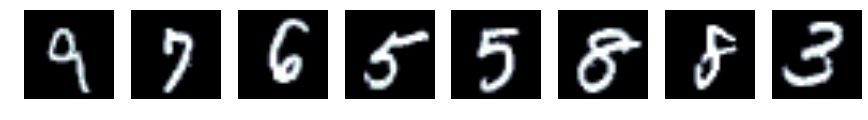

In [14]:
@interact(i=(0,10))
def plot_mnist(i=3):
    fig, ax = plt.subplots(ncols=8)
    fig.set_size_inches((15,4))
    for j in range(8):
        ax[j].imshow(mnist.train.images[i*8+j].reshape((28,28)),cmap="bone")
        ax[j].set_axis_off()

## map of conv1: size = (5,5)

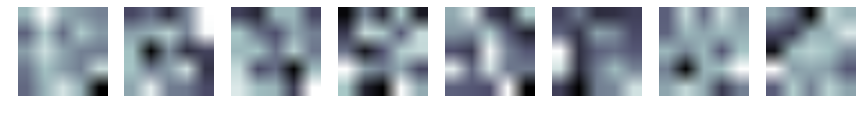

In [15]:
@interact(i=(0,3))
def plot_wc1(i=1):
    fig, ax = plt.subplots(ncols=8)
    fig.set_size_inches((15,4))
    for j in range(8):
        wc1_i = wc1_.reshape((25,32))[:,i*8+j].reshape((5,5))
        ax[j].imshow(wc1_i,cmap="bone")
        ax[j].set_axis_off()

## map of conv2: size = (5,5)

In [16]:
wc2_.shape

(5, 5, 32, 64)

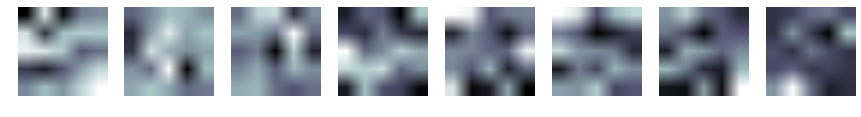

In [17]:
@interact(conv1=(0,31), i=(0,3))
def plot_wc1(conv1=5, i=1):
    fig, ax = plt.subplots(ncols=8)
    fig.set_size_inches((15,4))
    for j in range(8):
        wc2_i = wc2_.reshape((25,32,64))[:,conv1,:]
        wc2_i = wc2_i.reshape(25,64)[:,i*8+j].reshape((5,5))
        ax[j].imshow(wc2_i,cmap="bone")
        ax[j].set_axis_off()

# Launch Tensorboard

In [ ]:
%%bash
tensorboard --logdir=tensorflow_logs_cnn --port=6001

### Open http://localhost:6001/ into your web browser